## Reading in packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
import vaex
from IPython import display
from IPython.display import clear_output
import pyodbc

# Tensorflow related
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.compat.v2.feature_column as fc

#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v5

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix

2.2.0
C:\Users\PC\AppData\Local\Temp\tmptd9n5_0f\tensorboard_logs


## Extracting data

In [3]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec (1).csv
1: aggregateTAQ_May2020_30sec (1).csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


8


C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


In [4]:
files = os.listdir('../AzureML/Output_from_cloud')
files

['hyperparameters.txt', 'metrics.txt']

# Loading Neural Network

## Hyperparameters

In [5]:
### Reading in the file

with open('../AzureML/Output_from_cloud/'+files[0],'r') as file:
    content = file.readlines()

## Containers for the data
all_ids = []
all_parameters = []

## Going over each line in the text file
for a in np.arange(len(content)):
    
    ## Split the lines on tabs
    temp_parameters = re.split('[\t]',content[a])[1]
    
    ## Basic string cleaning, i.e. removing redundant characters
    test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
                                                                       .replace('}','')\
                                                                       .replace('\n','')\
                                                                       .replace('"',''))]
    
    ## Output of test is a list of lists, where each sublist holds the name of a model variable and its value.
    ## We create a dictornary to hold all model variables, making it easy to add the observation to the dataframe.
    test = {i[0]:i[1] for i in test}
    
    # Constructing the dataframe
    if a == 0:
        parameters = pd.DataFrame(test,index=[re.split('[\t]',content[a])[0]])
    
    else:
        
        parameters.loc[re.split('[\t]',content[a])[0]] = pd.Series(test)

In [6]:
parameters

,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,label-type,learning-rate,n-epochs,n-layers,nn-type,pastobs-in-percentage,pre-processing,second-layer-neurons
HD_81ace623-e09b-4393-8a5e-131ea8749a35_0,sigmoid,linear,0,1,3300,0.1,3,2,32,0,0.01,150,3,ffnn,1,stacked,64
HD_81ace623-e09b-4393-8a5e-131ea8749a35_1,sigmoid,linear,0,1,21450,0.1,1,1,64,1,0.1,150,3,ffnn,1,stacked,64
HD_81ace623-e09b-4393-8a5e-131ea8749a35_2,sigmoid,softmax,0,0,3300,0.4,0,2,32,4,0.1,150,2,ffnn,0,None,64
HD_81ace623-e09b-4393-8a5e-131ea8749a35_3,tanh,linear,0,0,10725,0.5,0,1,64,0,0.01,150,2,ffnn,0,quantgau,128
HD_81ace623-e09b-4393-8a5e-131ea8749a35_4,leakyrelu,linear,0,1,21450,0.4,1,2,128,0,0.001,150,2,lstm,1,None,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HD_81ace623-e09b-4393-8a5e-131ea8749a35_995,sigmoid,linear,1,0,21450,0.0,3,3,64,2,0.0001,150,4,ffnn,0,None,64
HD_81ace623-e09b-4393-8a5e-131ea8749a35_996,sigmoid,softmax,1,1,10725,0.0,3,0,64,1,0.01,150,4,ffnn,1,std,64
HD_81ace623-e09b-4393-8a5e-131ea8749a35_997,relu,linear,1,1,10725,0.5,3,2,64,3,0.0001,150,2,lstm,0,pow,64
HD_81ace623-e09b-4393-8a5e-131ea8749a35_998,sigmoid,softmax,0,0,21450,0.3,5,3,128,2,0.001,150,2,lstm,0,stacked,64


## Metrics

In [7]:
## Readidng in the file
with open('../AzureML/Output_from_cloud/'+files[1],'r') as file:
    content = file.readlines()

## Containers
t11 = []
t12 = []
t13 = []

t21 = []
t22 = []
t23 = []

## Going over each line
for i in np.arange(len(content)):#
    
    ## Split each line on tabs
    temp = re.split('\t',content[i].replace('\n',''))
    
    ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
    ## and 2. a time series of a metric for each model.
    
    ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
    ## It stored separately for the time series.
    if len(temp[2]) < 50:

        t11.append(temp[0])
        t12.append(temp[1])
        t13.append(temp[2])
    
    ## Time series
    else:
    
        container = np.zeros(155)
        temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

        container[0:len(temp1)] = temp1
        container[len(temp1):] = temp1[-1]

        t21.append(temp[0])
        t22.append(temp[1])
        t23.append(container)        

## Storing the time series in a dataframe
arrays = [t21,t22]
tuples = list(zip(*arrays))

runningMetrics = pd.DataFrame(np.array(t23),
                              index=pd.MultiIndex.from_tuples(tuples),
                              columns = [np.arange(155).astype(str)]
                             )
## Storing the final metrics in a dataframe.
arrays = [t11,t12]
tuples = list(zip(*arrays))
finalMetrics = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])

In [10]:
finalMetrics

size
HD_81ace623-e09b-4393-8a5e-131ea8749a35_1   Final test loss      0.8833522492045336
                                            Final test AUC       0.7648658156394958
                                            Final test accuracy  0.6109746098518372
HD_81ace623-e09b-4393-8a5e-131ea8749a35_3   Final test loss      1.1133369887535414
                                            Final test AUC        0.640163779258728
...                                                                             ...
HD_81ace623-e09b-4393-8a5e-131ea8749a35_997 Final test AUC       0.7837895154953003
                                            Final test accuracy   0.602816104888916
HD_81ace623-e09b-4393-8a5e-131ea8749a35_998 Final test loss      1.3713646207894699
                                            Final test AUC       0.7241190671920776
                                            Final test accuracy  0.4148908853530884

[1170 rows x 1 columns]

In [11]:
runningMetrics

0  \
HD_81ace623-e09b-4393-8a5e-131ea8749a35_0   Loss            1.098537   
                                            Accuracy        0.354843   
                                            AUC             0.500120   
                                            Train Loss      1.098558   
                                            Train Accuracy  0.344181   
...                                                              ...   
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999 Accuracy        0.337729   
                                            AUC             0.006679   
                                            Train Loss      5.383223   
                                            Train Accuracy  0.333057   
                                            Train AUC       0.030584   

                                                                   1  \
HD_81ace623-e09b-4393-8a5e-131ea8749a35_0   Loss            1.098504   
                                            Accuracy        0.358482   
                                            AUC             0.500277   
                                            Train Loss      1.098524   
                                            Train Accuracy  0.350251   
...                                                              ...   
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999 Accuracy        0.337729   
                                            AUC             0.003153   
                                            Train Loss      5.355752   
                                            Train Accuracy  0.332281   
                                            Train AUC       0.004384   

                                                                   2  \
HD_81ace623-e09b-4393-8a5e-131ea8749a35_0   Loss            1.098467   
                                            Accuracy        0.362843   
                                            AUC             0.500545   
                                            Train Loss      1.098487   
                                            Train Accuracy  0.353537   
...                                                              ...   
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999 Accuracy        0.337729   
                                            AUC             0.002064   
                                            Train Loss      5.355751   
                                            Train Accuracy  0.332281   
                                            Train AUC       0.002511   

                                                                   3  \
HD_81ace623-e09b-4393-8a5e-131ea8749a35_0   Loss            1.098423   
                                            Accuracy        0.365199   
                                            AUC             0.501018   
                                            Train Loss      1.098442   
                                            Train Accuracy  0.358348   
...                                                              ...   
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999 Accuracy        0.337729   
                                            AUC             0.001534   
                                            Train Loss      5.355751   
                                            Train Accuracy  0.332281   
                                            Train AUC       0.001766   

                                                                   4  \
HD_81ace623-e09b-4393-8a5e-131ea8749a35_0   Loss            1.098371   
                                            Accuracy        0.366960   
                                            AUC             0.501737   
                                            Train Loss      1.098396   
                                            Train Accuracy  0.360740   
...                                                              ...   
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999 Accuracy        0.337729   
                               

# Attaching the last observation of each model, for each metric, to the parameters of the model

In [12]:
## Resetting indcies and rename columns
runningMetrics = runningMetrics.reset_index().rename(columns={'level_0':'run_id','level_1':'metric'})
runningMetrics.columns = runningMetrics.columns.get_level_values(0)

## Adding a column of short ids, to merge on.
runningMetrics['id'] = [re.split('_',i)[-1] for i in runningMetrics.run_id]

## Creating a table, having the short id in the rows and the last observation for each metric in the columns. 
table = pd.pivot_table(runningMetrics[['run_id','metric','154','id']],index='id',columns=['metric'])
table.columns = table.columns.get_level_values(1)
table = table.round(5).reset_index()

## Preparing the parameter dataframe.
parameters = parameters.reset_index().rename(columns={'index':'run_id'})

## Setting short ID
parameters['id'] = [re.split('_',i)[-1] for i in parameters.run_id]

## Creating the combined table
combined_table = parameters.merge(table,
                                     on = 'id',
                                     how='left').sort_values('AUC',ascending=False)
combined_table

,run_id,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,...,pastobs-in-percentage,pre-processing,second-layer-neurons,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
115,HD_81ace623-e09b-4393-8a5e-131ea8749a35_115,relu,softmax,1,0,3300,0.2,1,3,128,...,1,quantgau,128,115,0.80363,0.58075,0.98257,0.80358,0.66548,0.77074
781,HD_81ace623-e09b-4393-8a5e-131ea8749a35_781,tanh,linear,1,1,21450,0.3,3,0,64,...,1,minmax,32,781,0.79064,0.57710,0.99908,0.79060,0.65135,0.80627
997,HD_81ace623-e09b-4393-8a5e-131ea8749a35_997,relu,linear,1,1,10725,0.5,3,2,64,...,0,pow,64,997,0.78380,0.60282,0.90322,0.78376,0.62677,0.84667
928,HD_81ace623-e09b-4393-8a5e-131ea8749a35_928,relu,linear,0,1,21450,0.4,1,0,64,...,0,std,32,928,0.78185,0.61228,0.89609,0.78181,0.62734,0.84895
128,HD_81ace623-e09b-4393-8a5e-131ea8749a35_128,tanh,linear,1,1,21450,0.3,0,2,64,...,1,None,128,128,0.78175,0.60582,0.92492,0.78172,0.62636,0.85098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,HD_81ace623-e09b-4393-8a5e-131ea8749a35_814,tanh,linear,0,0,3300,0.1,5,2,32,...,1,None,32,814,0.00000,0.19641,0.94736,0.00000,0.19952,0.95143
304,HD_81ace623-e09b-4393-8a5e-131ea8749a35_304,leakyrelu,linear,0,1,10725,0.1,0,1,32,...,1,minmax,32,304,0.00000,0.19329,0.89643,0.00000,0.18706,0.91432
195,HD_81ace623-e09b-4393-8a5e-131ea8749a35_195,sigmoid,linear,1,1,10725,0.5,5,3,64,...,0,None,128,195,0.00000,0.45457,0.68465,0.00000,0.45333,0.68717
861,HD_81ace623-e09b-4393-8a5e-131ea8749a35_861,relu,linear,1,1,3300,0.2,1,0,128,...,1,None,128,861,0.00000,0.16547,1.59072,0.00000,0.17433,1.59977


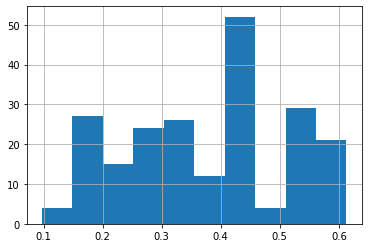

In [13]:
runningMetrics[(runningMetrics.metric=='Accuracy')&\
               (np.isin(runningMetrics.id,parameters[parameters['label-type']=='2'].id.values))].sort_values('154')['154'].hist()

In [14]:
## Creating a top-X table for each label-type of a given metric, here AUC.
temp_auc = pd.pivot_table(combined_table[['label-type','AUC','id']],index='id',columns='label-type')
temp_acc = pd.pivot_table(combined_table[['label-type','Accuracy','id']],index='id',columns='label-type')

## Final output - AUC
final_output_auc = pd.DataFrame(np.sort(temp_auc.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_auc.columns.get_level_values(1)).loc[0:10]
## Final output - Accuracy
final_output_acc = pd.DataFrame(np.sort(temp_acc.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_acc.columns.get_level_values(1))#.loc[0:10]
# final_output

In [19]:
list(combined_table.columns)

['run_id',
 'activation-inner',
 'activation-output',
 'batch-norm',
 'batch-shuffle',
 'batch-size',
 'dropout-ratio',
 'feature-lags',
 'featureset',
 'first-layer-neurons',
 'label-type',
 'learning-rate',
 'n-epochs',
 'n-layers',
 'nn-type',
 'pastobs-in-percentage',
 'pre-processing',
 'second-layer-neurons',
 'id',
 'AUC',
 'Accuracy',
 'Loss',
 'Train AUC',
 'Train Accuracy',
 'Train Loss']

In [17]:
tempFinal_v0 = combined_table[np.isin(combined_table.AUC,final_output_auc.loc[0].values.flatten())]
tempFinal_v0.index = tempFinal_v0.loc[:,'label-type']
tempFinal_v0

,run_id,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,...,pastobs-in-percentage,pre-processing,second-layer-neurons,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,,
1,HD_81ace623-e09b-4393-8a5e-131ea8749a35_115,relu,softmax,1,0,3300,0.2,1,3,128,...,1,quantgau,128,115,0.80363,0.58075,0.98257,0.80358,0.66548,0.77074
4,HD_81ace623-e09b-4393-8a5e-131ea8749a35_781,tanh,linear,1,1,21450,0.3,3,0,64,...,1,minmax,32,781,0.79064,0.57710,0.99908,0.79060,0.65135,0.80627
3,HD_81ace623-e09b-4393-8a5e-131ea8749a35_997,relu,linear,1,1,10725,0.5,3,2,64,...,0,pow,64,997,0.78380,0.60282,0.90322,0.78376,0.62677,0.84667
2,HD_81ace623-e09b-4393-8a5e-131ea8749a35_338,relu,linear,0,0,21450,0.2,0,1,64,...,0,quantgau,64,338,0.78078,0.60986,0.88815,0.78075,0.62015,0.86651
0,HD_81ace623-e09b-4393-8a5e-131ea8749a35_537,sigmoid,linear,1,1,10725,0.3,0,0,64,...,1,quantgau,32,537,0.77684,0.60628,0.89268,0.77681,0.61488,0.86622


In [16]:
tempFinal_v1 = combined_table[np.isin(combined_table.Accuracy,final_output_acc.loc[0].values.flatten())].sort_values('label-type').copy(deep=True)
tempFinal_v1.index = tempFinal_v1.loc[:,'label-type']
tempFinal_v1

,run_id,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,...,pastobs-in-percentage,pre-processing,second-layer-neurons,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,,
0,HD_81ace623-e09b-4393-8a5e-131ea8749a35_686,sigmoid,linear,1,1,21450,0.4,3,0,32,...,1,quantgau,32,686,0.75976,0.61322,0.88116,0.75970,0.61041,0.89109
1,HD_81ace623-e09b-4393-8a5e-131ea8749a35_716,relu,softmax,1,1,21450,0.4,3,0,32,...,1,pow,32,716,0.75923,0.61299,0.88144,0.75916,0.61234,0.88095
2,HD_81ace623-e09b-4393-8a5e-131ea8749a35_868,leakyrelu,linear,1,0,3300,0.4,0,0,32,...,0,std,64,868,0.76452,0.61282,0.88599,0.76448,0.60774,0.89207
3,HD_81ace623-e09b-4393-8a5e-131ea8749a35_717,leakyrelu,softmax,0,1,21450,0.0,5,3,32,...,0,None,128,717,0.76304,0.61409,0.87683,0.76298,0.61164,0.87896
4,HD_81ace623-e09b-4393-8a5e-131ea8749a35_133,tanh,softmax,1,1,10725,0.3,1,3,64,...,0,pow,64,133,0.76220,0.61248,0.88257,0.76215,0.61133,0.88838


In [22]:
list(combined_table.columns)

['run_id',
 'activation-inner',
 'activation-output',
 'batch-norm',
 'batch-shuffle',
 'batch-size',
 'dropout-ratio',
 'feature-lags',
 'featureset',
 'first-layer-neurons',
 'label-type',
 'learning-rate',
 'n-epochs',
 'n-layers',
 'nn-type',
 'pastobs-in-percentage',
 'pre-processing',
 'second-layer-neurons',
 'id',
 'AUC',
 'Accuracy',
 'Loss',
 'Train AUC',
 'Train Accuracy',
 'Train Loss']

## An example of a box-plot

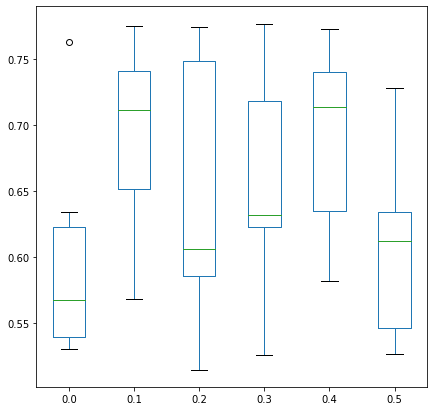

In [82]:
temp = combined_table[(combined_table.loc[:,'label-type']=='0')&(combined_table.loc[:,'nn-type']=='lstm')&(combined_table.AUC>0.5)]
temp_2 = pd.pivot_table(temp,values='AUC',columns='dropout-ratio',index='run_id').reset_index()
temp_2.boxplot(list(temp_2.columns[1:]),figsize=(7,7))#temp_2.columns[2:]
plt.grid(b=None)
plt.show()

In [71]:
temp.loc[:,'dropout-ratio'].unique()

array(['0.3', '0.1', '0.2', '0.4', '0.0', '0.5'], dtype=object)

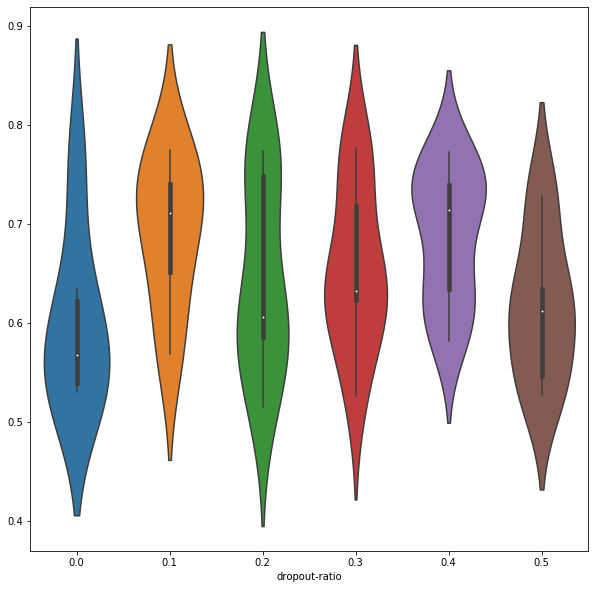

In [79]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(10,10))
# sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
# ax = sns.violinplot(x=tips["total_bill"])
sns.violinplot(data=temp_2,ax=ax,bw='scott')
plt.show()

# Loading Logistic Regression

In [86]:
os.listdir('../AzureML/Output_from_cloud')

['hyperparameters.txt',
 'hyperparameters_lr_v1.txt',
 'hyperparameters_lr_v2.txt',
 'metrics.txt',
 'metrics_lr_v1.txt',
 'metrics_lr_v2.txt']

In [87]:
hyperfiles = [i for i in os.listdir('../AzureML/Output_from_cloud') if 'hyper' in i]
metricfiles = [i for i in os.listdir('../AzureML/Output_from_cloud') if 'metric' in i]

In [88]:
hyperfiles

['hyperparameters.txt',
 'hyperparameters_lr_v1.txt',
 'hyperparameters_lr_v2.txt']

In [171]:
for j,file in enumerate(hyperfiles):
    
    if j > 0:
        
        ### Reading in the file

        with open('../AzureML/Output_from_cloud/'+hyperfiles[j],'r') as file:
            content = file.readlines()

        ## Going over each line in the text file
        for a in np.arange(len(content)):

            ## Split the lines on tabs
            temp_parameters = re.split('[\t]',content[a])[1]

            ## Basic string cleaning, i.e. removing redundant characters
            test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
                                                                               .replace('}','')\
                                                                               .replace('\n','')\
                                                                               .replace('"',''))]

            ## Output of test is a list of lists, where each sublist holds the name of a model variable and its value.
            ## We create a dictornary to hold all model variables, making it easy to add the observation to the dataframe.
            test = {i[0]:i[1] for i in test}

            # Constructing the dataframe
            if (a == 0)&(j==1):
                parameters_lr = pd.DataFrame(test,index=[re.split('[\t]',content[a])[0]])

            else:

                parameters_lr.loc[re.split('[\t]',content[a])[0]] = pd.Series(test)
        
#         lastone = a

In [92]:
parameters_lr

,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,label-type,learning-rate,loss-from-logits,n-epochs,pastobs-in-percentage,pre-processing
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0,1,21450,5,1,1.0,6,2,0.001,0,150,1,stacked
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_1,0,3300,1,2,10.0,1,2,0.1,0,150,1,quantgau
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_2,1,10725,5,2,0.1,1,0,0.001,0,150,1,pow
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_3,1,3300,5,1,100.0,4,0,0.001,1,150,1,minmax
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_4,0,21450,5,3,0.01,5,2,0.0001,1,150,1,std
...,...,...,...,...,...,...,...,...,...,...,...,...
HD_914f915c-2cac-473e-bea5-c26e4c83673c_98,1,10725,3,2,10000000000.0,5,4,0.01,1,150,0,None
HD_914f915c-2cac-473e-bea5-c26e4c83673c_99,1,3300,0,0,0.0001,6,0,0.001,1,150,1,None
HD_914f915c-2cac-473e-bea5-c26e4c83673c_100,1,21450,3,1,1000.0,5,1,0.001,0,150,0,std
HD_914f915c-2cac-473e-bea5-c26e4c83673c_101,0,10725,3,0,1.0,5,3,0.0001,1,150,1,pow


In [178]:
for j,file in enumerate(metricfiles):
    
    if j > 0:#) & (j<2)
        
        ## Readidng in the file
        with open('../AzureML/Output_from_cloud/'+metricfiles[j],'r') as file:
            content = file.readlines()

        ## Containers
        t11 = []
        t12 = []
        t13 = []

        t21 = []
        t22 = []
        t23 = []

        ## Going over each line
        for i in np.arange(len(content)):#

            ## Split each line on tabs
            temp = re.split('\t',content[i].replace('\n',''))

            ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
            ## and 2. a time series of a metric for each model.

            ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
            ## It stored separately for the time series.
            if len(temp[2]) < 50:

                t11.append(temp[0])
                t12.append(temp[1])
                t13.append(temp[2])

            ## Time series
            else:

                container = np.zeros(155)
                temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

                container[0:len(temp1)] = temp1
                container[len(temp1):] = temp1[-1]

                t21.append(temp[0])
                t22.append(temp[1])
                t23.append(container)        

        ## Storing the time series in a dataframe
        arrays = [t21,t22]
        tuples = list(zip(*arrays))
        if j == 1:
            
            runningMetrics_lr = pd.DataFrame(np.array(t23),
                                              index=pd.MultiIndex.from_tuples(tuples),
                                              columns = [np.arange(155).astype(str)]
                                             )
        else:
            temp_1 = pd.DataFrame(np.array(t23),
                                  index=pd.MultiIndex.from_tuples(tuples),
                                  columns = [np.arange(155).astype(str)])
            runningMetrics_lr = pd.concat([runningMetrics_lr,temp_1])
        ## Storing the final metrics in a dataframe.
        arrays = [t11,t12]
        tuples = list(zip(*arrays))
        if j == 1:
            
            finalMetrics_lr = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])
        else:
            
            temp = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])
            finalMetrics_lr = pd.concat([finalMetrics_lr,temp],axis = 0)

In [165]:
runningMetrics_lr

0  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss              1.097134   
                                            Accuracy          0.357927   
                                            AUC               0.520483   
                                            Train Loss        1.103421   
                                            Train Accuracy    0.348293   
...                                                                ...   
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Accuracy          0.320367   
                                            AUC               0.504284   
                                            Train Loss      277.681401   
                                            Train Accuracy    0.346011   
                                            Train AUC         0.501814   

                                                                    1  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.089486   
                                            Accuracy         0.372786   
                                            AUC              0.533294   
                                            Train Loss       1.092251   
                                            Train Accuracy   0.370394   
...                                                               ...   
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Accuracy         0.339238   
                                            AUC              0.504207   
                                            Train Loss      37.135827   
                                            Train Accuracy   0.342229   
                                            Train AUC        0.503613   

                                                                    2  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.084925   
                                            Accuracy         0.380087   
                                            AUC              0.543315   
                                            Train Loss       1.085799   
                                            Train Accuracy   0.381516   
...                                                               ...   
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Accuracy         0.328944   
                                            AUC              0.505291   
                                            Train Loss      10.825353   
                                            Train Accuracy   0.344201   
                                            Train AUC        0.504672   

                                                                   3  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss            1.082050   
                                            Accuracy        0.386206   
                                            AUC             0.550682   
                                            Train Loss      1.081776   
                                            Train Accuracy  0.386821   
...                                                              ...   
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Accuracy        0.305141   
                                            AUC             0.505693   
                                            Train Loss      5.201888   
                                            Train Accuracy  0.353328   
                                            Train AUC       0.505701   

                                                                   4  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss            1.080157   
                                            Accuracy        0.388733   
                                            AUC             0.556136   
                                            Train Loss      1.079140   
                                            Train Accuracy  0.390184   
...                                                              ...   
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Accuracy     

In [167]:
list(runningMetrics.columns)

[('0',),
 ('1',),
 ('2',),
 ('3',),
 ('4',),
 ('5',),
 ('6',),
 ('7',),
 ('8',),
 ('9',),
 ('10',),
 ('11',),
 ('12',),
 ('13',),
 ('14',),
 ('15',),
 ('16',),
 ('17',),
 ('18',),
 ('19',),
 ('20',),
 ('21',),
 ('22',),
 ('23',),
 ('24',),
 ('25',),
 ('26',),
 ('27',),
 ('28',),
 ('29',),
 ('30',),
 ('31',),
 ('32',),
 ('33',),
 ('34',),
 ('35',),
 ('36',),
 ('37',),
 ('38',),
 ('39',),
 ('40',),
 ('41',),
 ('42',),
 ('43',),
 ('44',),
 ('45',),
 ('46',),
 ('47',),
 ('48',),
 ('49',),
 ('50',),
 ('51',),
 ('52',),
 ('53',),
 ('54',),
 ('55',),
 ('56',),
 ('57',),
 ('58',),
 ('59',),
 ('60',),
 ('61',),
 ('62',),
 ('63',),
 ('64',),
 ('65',),
 ('66',),
 ('67',),
 ('68',),
 ('69',),
 ('70',),
 ('71',),
 ('72',),
 ('73',),
 ('74',),
 ('75',),
 ('76',),
 ('77',),
 ('78',),
 ('79',),
 ('80',),
 ('81',),
 ('82',),
 ('83',),
 ('84',),
 ('85',),
 ('86',),
 ('87',),
 ('88',),
 ('89',),
 ('90',),
 ('91',),
 ('92',),
 ('93',),
 ('94',),
 ('95',),
 ('96',),
 ('97',),
 ('98',),
 ('99',),
 ('100',),

In [118]:
os.listdir('../AzureML/Output_from_cloud/')

['hyperparameters.txt',
 'hyperparameters_lr_v1.txt',
 'hyperparameters_lr_v2.txt',
 'hyperparameters_lr_v3.txt',
 'metrics.txt',
 'metrics_lr_v1.txt',
 'metrics_lr_v2.txt',
 'metrics_lr_v3.txt']

In [147]:
with open('../AzureML/Output_from_cloud/'+metricfiles[1],'r') as file:
    content = file.readlines()
        
## Containers
t11 = []
t12 = []
t13 = []

t21 = []
t22 = []
t23 = []

## Going over each line
for i in np.arange(len(content)):#

    ## Split each line on tabs
    temp = re.split('\t',content[i].replace('\n',''))

    ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
    ## and 2. a time series of a metric for each model.

    ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
    ## It stored separately for the time series.
    if len(temp[2]) < 50:

        t11.append(temp[0])
        t12.append(temp[1])
        t13.append(temp[2])

    ## Time series
    else:

        container = np.zeros(155)
        temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

        container[0:len(temp1)] = temp1
        container[len(temp1):] = temp1[-1]

        t21.append(temp[0])
        t22.append(temp[1])
        t23.append(container)    
        
print([i for i,j in enumerate(t11) if j == 'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_1'])
print([i for i,j in enumerate(t21) if j == 'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_1'])

[3, 4, 5]
[6, 7, 8, 9, 10, 11]


In [150]:
print(t12[5],t13[5])
print(t22[10],t23[10][-1])

Final test accuracy 0.6106547117233276
Train Accuracy 0.6087145209312439


Train Accuracy 0.6087145209312439


In [152]:
with open('../AzureML/Output_from_cloud/'+metricfiles[2],'r') as file:
    content = file.readlines()
        
## Containers
t11 = []
t12 = []
t13 = []

t21 = []
t22 = []
t23 = []

## Going over each line
for i in np.arange(len(content)):#

    ## Split each line on tabs
    temp = re.split('\t',content[i].replace('\n',''))

    ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
    ## and 2. a time series of a metric for each model.

    ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
    ## It stored separately for the time series.
    if len(temp[2]) < 50:

        t11.append(temp[0])
        t12.append(temp[1])
        t13.append(temp[2])

    ## Time series
    else:

        container = np.zeros(155)
        temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

        container[0:len(temp1)] = temp1
        container[len(temp1):] = temp1[-1]

        t21.append(temp[0])
        t22.append(temp[1])
        t23.append(container)   

print([i for i,j in enumerate(t11) if j == 'HD_914f915c-2cac-473e-bea5-c26e4c83673c_1'])
print([i for i,j in enumerate(t21) if j == 'HD_914f915c-2cac-473e-bea5-c26e4c83673c_1'])

[3, 4, 5]
[6, 7, 8, 9, 10, 11]


In [153]:
print(t12[5],t13[5])
print(t22[10],t23[10][-1])

Final test accuracy 0.6057029366493225
Train Accuracy 0.6022814512252808


In [98]:
finalMetrics_lr

size
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Final test loss       1.0703172176779956
                                            Final test AUC        0.5924146175384521
                                            Final test accuracy   0.4012987017631531
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_1   Final test loss       0.9833228082609005
                                            Final test AUC        0.7488732933998108
...                                                                              ...
HD_914f915c-2cac-473e-bea5-c26e4c83673c_100 Final test AUC       0.12177372723817825
                                            Final test accuracy  0.22250525653362274
HD_914f915c-2cac-473e-bea5-c26e4c83673c_101 Final test loss       0.7250796820548917
                                            Final test AUC          0.54725581407547
                                            Final test accuracy   0.5373607873916626

[1413 rows x 1 columns]

In [99]:
runningMetrics_lr

0  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss            1.097134   
                                            Accuracy        0.357927   
                                            AUC             0.520483   
                                            Train Loss      1.103421   
                                            Train Accuracy  0.348293   
...                                                              ...   
HD_914f915c-2cac-473e-bea5-c26e4c83673c_101 Accuracy        0.545000   
                                            AUC             0.550652   
                                            Train Loss      0.704141   
                                            Train Accuracy  0.531084   
                                            Train AUC       0.534949   

                                                                   1  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss            1.089486   
                                            Accuracy        0.372786   
                                            AUC             0.533294   
                                            Train Loss      1.092251   
                                            Train Accuracy  0.370394   
...                                                              ...   
HD_914f915c-2cac-473e-bea5-c26e4c83673c_101 Accuracy        0.528089   
                                            AUC             0.546950   
                                            Train Loss      0.722193   
                                            Train Accuracy  0.526480   
                                            Train AUC       0.548933   

                                                                   2  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss            1.084925   
                                            Accuracy        0.380087   
                                            AUC             0.543315   
                                            Train Loss      1.085799   
                                            Train Accuracy  0.381516   
...                                                              ...   
HD_914f915c-2cac-473e-bea5-c26e4c83673c_101 Accuracy        0.534760   
                                            AUC             0.546178   
                                            Train Loss      0.718967   
                                            Train Accuracy  0.528231   
                                            Train AUC       0.546634   

                                                                   3  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss            1.082050   
                                            Accuracy        0.386206   
                                            AUC             0.550682   
                                            Train Loss      1.081776   
                                            Train Accuracy  0.386821   
...                                                              ...   
HD_914f915c-2cac-473e-bea5-c26e4c83673c_101 Accuracy        0.533022   
                                            AUC             0.545355   
                                            Train Loss      0.727249   
                                            Train Accuracy  0.525877   
                                            Train AUC       0.545650   

                                                                   4  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss            1.080157   
                                            Accuracy        0.388733   
                                            AUC             0.556136   
                                            Train Loss      1.079140   
                                            Train Accuracy  0.390184   
...                                                              ...   
HD_914f915c-2cac-473e-bea5-c26e4c83673c_101 Accuracy        0.537606   
                               

# Attaching the last observation of each model, for each metric, to the parameters of the model

In [179]:
## Resetting indcies and rename columns
runningMetrics_lr = runningMetrics_lr.reset_index().rename(columns={'level_0':'run_id','level_1':'metric'})
runningMetrics_lr.columns = runningMetrics_lr.columns.get_level_values(0)

## Adding a column of short ids, to merge on.
runningMetrics_lr['id'] = np.arange(runningMetrics_lr.shape[0]).astype(str)#[re.split('_',i)[-1] for i in runningMetrics_lr.run_id]

## Creating a table, having the short id in the rows and the last observation for each metric in the columns. 
table_lr = pd.pivot_table(runningMetrics_lr[['run_id','metric','154','id']],index='id',columns=['metric'])
table_lr.columns = table_lr.columns.get_level_values(1)
table_lr = table_lr.round(7).reset_index()

## Preparing the parameter dataframe.
parameters_lr = parameters_lr.reset_index().rename(columns={'index':'run_id'})

## Setting short ID
parameters_lr['id'] = np.arange(parameters_lr.shape[0]).astype(str)#[re.split('_',i)[-1] for i in parameters_lr.run_id]

## Creating the combined table
combined_table_lr = parameters_lr.merge(table_lr,
                                     on = 'id',
                                     how='left').sort_values('AUC',ascending=False)
combined_table_lr

,run_id,run_id,run_id,run_id,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,...,n-epochs,pastobs-in-percentage,pre-processing,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
344,344,344,344,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_344,1,10725,1,0,10000000000.0,4,...,150,0,std,344,0.769295,NaN,NaN,NaN,NaN,NaN
8,8,8,8,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_8,0,3300,1,0,0.1,4,...,150,1,std,8,0.748841,NaN,NaN,NaN,NaN,NaN
194,194,194,194,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_194,1,10725,0,0,0.001,6,...,150,1,None,194,0.743498,NaN,NaN,NaN,NaN,NaN
326,326,326,326,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_326,0,10725,5,2,0.01,4,...,150,0,stacked,326,0.736580,NaN,NaN,NaN,NaN,NaN
278,278,278,278,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_278,1,3300,3,2,0.1,6,...,150,0,stacked,278,0.734464,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,478,478,478,HD_914f915c-2cac-473e-bea5-c26e4c83673c_97,1,21450,5,2,10000000000.0,3,...,150,1,std,478,NaN,NaN,NaN,NaN,0.552116,NaN
479,479,479,479,HD_914f915c-2cac-473e-bea5-c26e4c83673c_98,1,10725,3,2,10000000000.0,5,...,150,0,None,479,NaN,NaN,NaN,0.465899,NaN,NaN
480,480,480,480,HD_914f915c-2cac-473e-bea5-c26e4c83673c_99,1,3300,0,0,0.0001,6,...,150,1,None,480,NaN,NaN,146285.365738,NaN,NaN,NaN
481,481,481,481,HD_914f915c-2cac-473e-bea5-c26e4c83673c_100,1,21450,3,1,1000.0,5,...,150,0,std,481,NaN,0.19385,NaN,NaN,NaN,NaN


In [180]:
## Creating a top-X table for each label-type of a given metric, here AUC.
temp_auc_lr = pd.pivot_table(combined_table_lr[['label-type','AUC','id']],index='id',columns='label-type')
temp_acc_lr = pd.pivot_table(combined_table_lr[['label-type','Accuracy','id']],index='id',columns='label-type')

## Final output - AUC
final_output_auc_lr = pd.DataFrame(np.sort(temp_auc_lr.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_auc_lr.columns.get_level_values(1)).loc[0:10]
## Final output - Accuracy
final_output_acc_lr = pd.DataFrame(np.sort(temp_acc_lr.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_acc_lr.columns.get_level_values(1))#.loc[0:10]
# final_output

In [181]:
tempFinal_v0_lr = combined_table_lr[np.isin(combined_table_lr.AUC,final_output_auc_lr.loc[0].values.flatten())]
tempFinal_v0_lr.index = tempFinal_v0_lr.loc[:,'label-type']
tempFinal_v0_lr

,run_id,run_id,run_id,run_id,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,...,n-epochs,pastobs-in-percentage,pre-processing,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,,
2,344,344,344,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_344,1,10725,1,0,10000000000.0,4,...,150,0,std,344,0.769295,NaN,NaN,NaN,NaN,NaN
1,8,8,8,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_8,0,3300,1,0,0.1,4,...,150,1,std,8,0.748841,NaN,NaN,NaN,NaN,NaN
0,194,194,194,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_194,1,10725,0,0,0.001,6,...,150,1,None,194,0.743498,NaN,NaN,NaN,NaN,NaN
3,326,326,326,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_326,0,10725,5,2,0.01,4,...,150,0,stacked,326,0.736580,NaN,NaN,NaN,NaN,NaN
4,278,278,278,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_278,1,3300,3,2,0.1,6,...,150,0,stacked,278,0.734464,NaN,NaN,NaN,NaN,NaN


In [182]:
final_output_acc_lr.loc[0]

label-type
0    0.609582
1    0.519679
2    0.606345
3    0.610655
4    0.609793
Name: 0, dtype: float64

In [183]:
tempFinal_v1_lr = combined_table_lr[np.isin(combined_table_lr.Accuracy,final_output_acc_lr.loc[0].values.flatten())].sort_values('label-type').copy(deep=True)
tempFinal_v1_lr.index = tempFinal_v1_lr.loc[:,'label-type']
tempFinal_v1_lr

,run_id,run_id,run_id,run_id,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,...,n-epochs,pastobs-in-percentage,pre-processing,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,,
0,439,439,439,HD_914f915c-2cac-473e-bea5-c26e4c83673c_58,0,21450,0,2,1000.0,5,...,150,0,std,439,NaN,0.609582,NaN,NaN,NaN,NaN
1,157,157,157,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_157,0,21450,1,1,10000000000.0,6,...,150,1,minmax,157,NaN,0.519679,NaN,NaN,NaN,NaN
2,259,259,259,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_259,0,21450,3,1,10.0,5,...,150,1,minmax,259,NaN,0.606345,NaN,NaN,NaN,NaN
3,7,7,7,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_7,1,3300,5,1,0.1,1,...,150,1,quantgau,7,NaN,0.610655,NaN,NaN,NaN,NaN
4,343,343,343,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_343,1,21450,1,1,10000.0,2,...,150,0,None,343,NaN,0.609793,NaN,NaN,NaN,NaN


In [162]:
list(combined_table_lr.columns)

['run_id',
 'batch-shuffle',
 'batch-size',
 'feature-lags',
 'featureset',
 'l2-penalty',
 'l2-type',
 'label-type',
 'learning-rate',
 'loss-from-logits',
 'n-epochs',
 'pastobs-in-percentage',
 'pre-processing',
 'id',
 'AUC',
 'Accuracy',
 'Loss',
 'Train AUC',
 'Train Accuracy',
 'Train Loss']

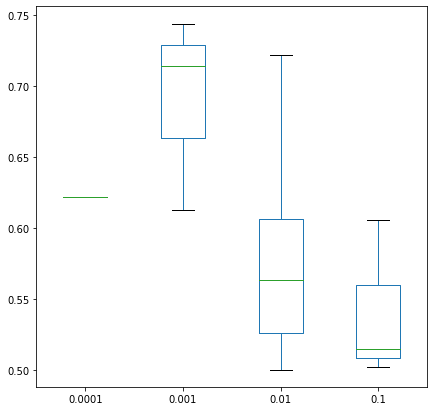

In [163]:
temp_lr = combined_table_lr[(combined_table_lr.loc[:,'label-type']=='0')&\
                            (combined_table_lr.loc[:,'loss-from-logits']=='1')&\
                            (combined_table_lr.AUC>0.5)]
temp_2_lr = pd.pivot_table(temp_lr,
                        values='AUC',
                        columns='learning-rate',
                        index='run_id').reset_index()
temp_2_lr.boxplot(list(temp_2_lr.columns[1:]),
                  figsize=(7,7))#temp_2.columns[2:]
plt.grid(b=None)
plt.show()

# reading in the market data (done automatically atm)

In [3]:
file

'8'

In [4]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385   91.500   91.755   91.485   91.740         0.42         0.93   
         386   91.740   91.740   91.740   91.740         0.50         0.50   
         387   91.580   91.830   91.580   91.715         0.18         0.68   
         388   91.595   91.880   91.595   91.750         0.21         0.78   
         389   46.005   46.005   45.815   45.815        92.01        92.01   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.39          0.50           5.0           5.0   
         386        0.50          0.50           5.0           5.0   
         387        0.18          0.45           5.0           5.0   
         388        0.21          0.52           5.0           5.0   
         389       91.63         91.63           0.0           0.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          5.0            5.0           1.0           5.0   
         386          5.0            5.0           5.0           5.0   
         387          5.0            5.0           1.0           5.0   
         388          5.0            5.0           1.0           5.0   
         389          0.0            0.0           5.0           5.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            5.0   XNTK         NaN  
         386          5.0            5.0   XNTK         NaN  
         387          1.0            5.0   XNTK         NaN  
         388          1.0            5.0   XNTK         NaN  
         389          1.0            1.0   XNTK         NaN  

[546000 rows x 18 columns]

In [5]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385   91.500   91.755   91.485   91.740         0.42         0.93   
         386   91.740   91.740   91.740   91.740         0.50         0.50   
         387   91.580   91.830   91.580   91.715         0.18         0.68   
         388   91.595   91.880   91.595   91.750         0.21         0.78   
         389   46.005   46.005   45.815   45.815        92.01        92.01   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.39          0.50           5.0           5.0   
         386        0.50          0.50           5.0           5.0   
         387        0.18          0.45           5.0           5.0   
         388        0.21          0.52           5.0           5.0   
         389       91.63         91.63           0.0           0.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          5.0            5.0           1.0           5.0   
         386          5.0            5.0           5.0           5.0   
         387          5.0            5.0           1.0           5.0   
         388          5.0            5.0           1.0           5.0   
         389          0.0            0.0           5.0           5.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            5.0   XNTK         NaN  
         386          5.0            5.0   XNTK         NaN  
         387          1.0            5.0   XNTK         NaN  
         388          1.0            5.0   XNTK         NaN  
         389          1.0            1.0   XNTK         NaN  

[546000 rows x 18 columns]

In [6]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

### Dropping ETFS and market indices

In [4]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY', 'XNTK'], dtype=object)

In [5]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [6]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY'], dtype=object)

In [7]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [8]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

In [9]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            4.0   AAPL          Technology  
         1            1.0            1.0   AAPL          Technology  
         2            1.0            1.0   AAPL          Technology  
         3            1.0            1.0   AAPL          Technology  
         4            1.0            1.0   AAPL          Technology  
...                   ...            ...    ...                 ...  
20200529 385          1.0            1.0    WMT  Consumer Defensive  
         386          1.0            2.0    WMT  Consumer Defensive  
         387          1.0            2.0    WMT  Consumer Defensive  
         388          1.0            4.0    WMT  Consumer Defensive  
         389          1.0            1.0    WMT  Consumer Defensive  

[429000 rows x 18 columns]

In [10]:
########### Generate Features ################

n_feature_lags = 1

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
#                                                     'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                      'macd_diff',
                                                      'macd_signal',
                                                    'dis5',
                                                    'dis10',
                                                      'sector'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 2
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y,indices = align_features_and_labels_multi_final(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,ticker_dummies=False)

INFO:MainThread:numexpr.utils:NumExpr defaulting to 4 threads.
C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


AAPL done
ABBV done
ABT done
AEP done
AMT done
APD done
BA done
BABA done
BAC done
BHP done
BP done
CCI done
CHL done
COST done
CSGP done
D done
DIS done
ECL done
ENB done
EXC done
FB done
FMX done
GOOG done
INTC done
JNJ done
KO done
LFC done
LIN done
LMT done
MA done
MCD done
MSFT done
NKE done
NVDA done
NVS done
Number of NaNs in label: 1. 1 is expected
Returns that lead to NaNs in label: [0.0907158]
PBR done
PEP done
PFE done
PLD done
PSA done
PTR done
PYPL done
RTX done
SHW done
SNP done
SO done
SRE done
T done
TM done
TSLA done
TSM done
UNP done
UPS done
V done
WMT done


## Splitting the data

## Adding ticker dummies

In [14]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='ticker', drop_first=False)], axis=1)

In [15]:
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'spread_open_lag0',
       'spread_high_lag0', 'spread_low_lag0', 'spread_close_lag0',
       'bidsize_open_lag0', 'bidsize_high_lag0',
       ...
       'ticker_SO', 'ticker_SRE', 'ticker_T', 'ticker_TM', 'ticker_TSLA',
       'ticker_TSM', 'ticker_UNP', 'ticker_UPS', 'ticker_V', 'ticker_WMT'],
      dtype='object', length=156)

## Constructing our final train/validation sets

In [16]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(341385, 156)
(341385, 1)
(85690, 156)
(85690, 1)


In [17]:
X_train

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,ticker_SO,ticker_SRE,ticker_T,ticker_TM,ticker_TSLA,ticker_TSM,ticker_UNP,ticker_UPS,ticker_V,ticker_WMT
0,-0.545,0.205,-0.635,296.440,0.09,0.20,0.01,0.06,1.0,12.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.200,0.040,-0.255,82.805,0.21,0.26,0.01,0.07,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
2,0.000,0.030,-0.040,90.855,0.07,0.10,0.01,0.09,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,0.100,0.140,-0.110,81.510,0.06,0.25,0.03,0.16,1.0,9.0,...,0,0,0,0,0,0,0,0,0,0
4,0.010,0.070,-0.045,234.230,0.26,0.30,0.11,0.18,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341380,0.035,0.165,-0.040,51.300,0.17,0.26,0.01,0.02,5.0,23.0,...,0,0,0,0,0,1,0,0,0,0
341381,0.890,0.965,-0.290,169.435,0.35,1.41,0.01,0.93,1.0,10.0,...,0,0,0,0,0,0,1,0,0,0
341382,0.105,0.235,-0.465,97.955,0.86,1.32,0.06,0.15,1.0,6.0,...,0,0,0,0,0,0,0,1,0,0
341383,-0.080,0.540,-0.245,195.705,0.75,1.08,0.01,0.07,1.0,4.0,...,0,0,0,0,0,0,0,0,1,0


In [21]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


(array([], dtype=int64),)

## Pre-processing

In [ ]:
{i:colname for i,colname in enumerate(train_ds.columns)}

In [22]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing(X_train,X_test,ppdict)

In [53]:
ppX_train.iloc[:,0].mean(),ppX_train.iloc[:,0].std()

(-1.8927265537610815e-16, 1.000001457346533)

## Prepping for models

In [8]:
N_VALIDATION = val_y.shape[0] #int(1e3)
N_TRAIN = train_y.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

(343090, 85800, 428890, 1340, 131, 670000)

## A Logistic Regression model in TF/Keras

In [55]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(1,
                       input_shape=(FEATURES,),
                       activation='sigmoid',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_auc', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=0) #(val_features, val_labels))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 99        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.5352,  auc:0.5034,  loss:0.8996,  val_accuracy:0.5456,  val_auc:0.5453,  val_loss:0.6876,  
....................................................................................................
Epoch: 100, accuracy:0.5480,  auc:0.5440,  loss:0.6873,  val_accuracy:0.5454,  val_auc:0.5459,  val_loss:0.6879,  
..................Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping


In [56]:
model.evaluate(validate_ds,  val_y, verbose=2)

2682/2682 - 6s - loss: 0.6879 - accuracy: 0.5457 - auc: 0.5513


[0.6878659725189209, 0.5456876754760742, 0.5513222217559814]

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [12]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 9296.